In [1]:
using Plots, JLD, Base.Filesystem, OffsetArrays, LaTeXStrings
import OffsetArrays: no_offset_view

## Prepare measurements
Generate config files

In [11]:
function generateConfig(line, target_rank, sparse_rel_thresh, SNR_dB)
    open("third_trial/l$(line)_r$(target_rank)_s$(round(Int,sparse_rel_thresh*10))_$SNR_dB.conf", "w") do f
        write(f, """
# Parameters of data
line                $line
target_rank         $target_rank
sparse_rel_thresh   $sparse_rel_thresh
SNR_dB              $SNR_dB

# Parameters of algorithms
maxIter_IRLS        50
N_IRLS              15
N_CG                400
N_AL2               1500
N_ISTA              1500
N_FISTA             1500
N_POGM              1500
N_MSLR              1500
        """)
    end
end

generateConfig (generic function with 1 method)

In [12]:
# Investigate noise-tolerance
generateConfig(24, 8, 0.1, 20)
generateConfig(24, 8, 0.1, 40)
generateConfig(24, 8, 0.1, 80)
generateConfig(24, 8, 0.1, 120)
generateConfig(24, 8, 0.1, 160)
generateConfig(24, 8, 0.1, Inf)

# Investigate the lowest number of sufficient measurement
generateConfig(18, 8, 0.1, Inf)
generateConfig(12, 8, 0.1, Inf)
generateConfig(6, 8, 0.1, Inf)
generateConfig(5, 8, 0.1, Inf)
generateConfig(4, 8, 0.1, Inf)
generateConfig(3, 8, 0.1, Inf)
generateConfig(2, 8, 0.1, Inf)
generateConfig(1, 8, 0.1, Inf)

344

## Visualize results

In [2]:
plot_size = (1200, 400)

(1200, 400)

### Plot against time

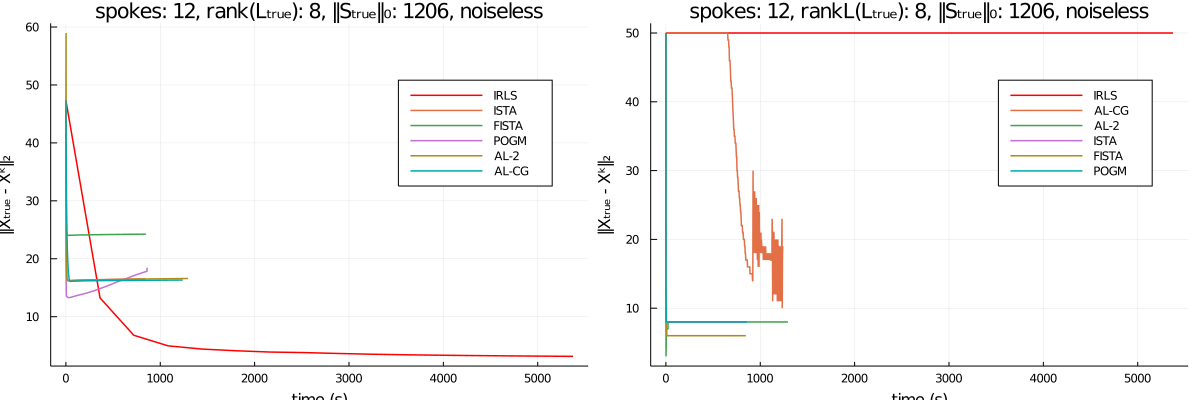

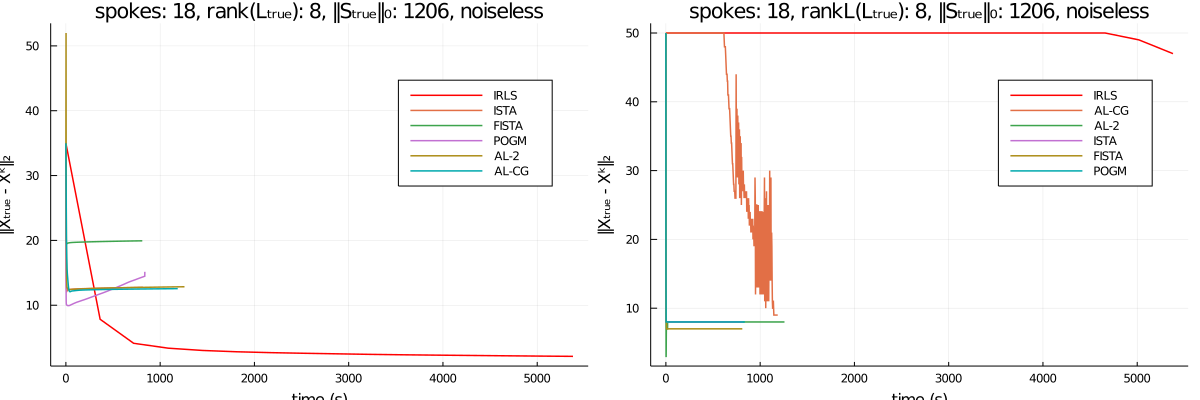

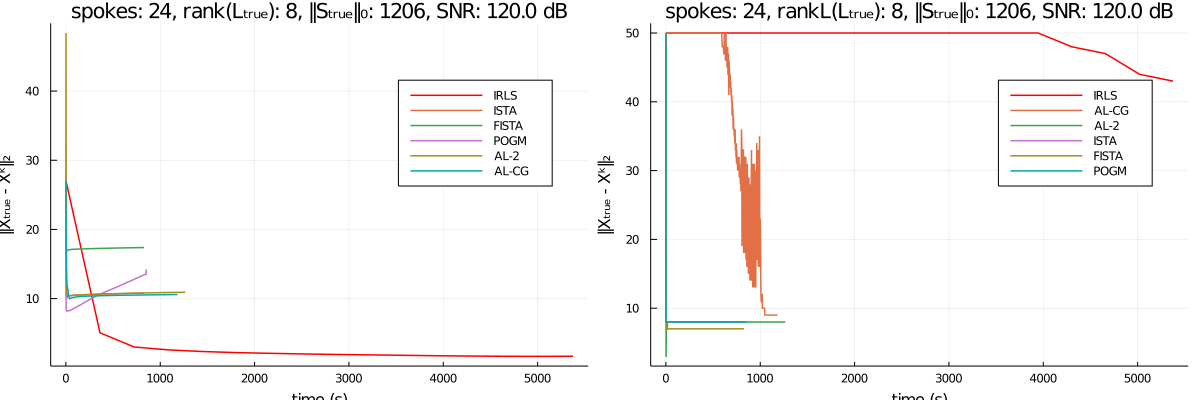

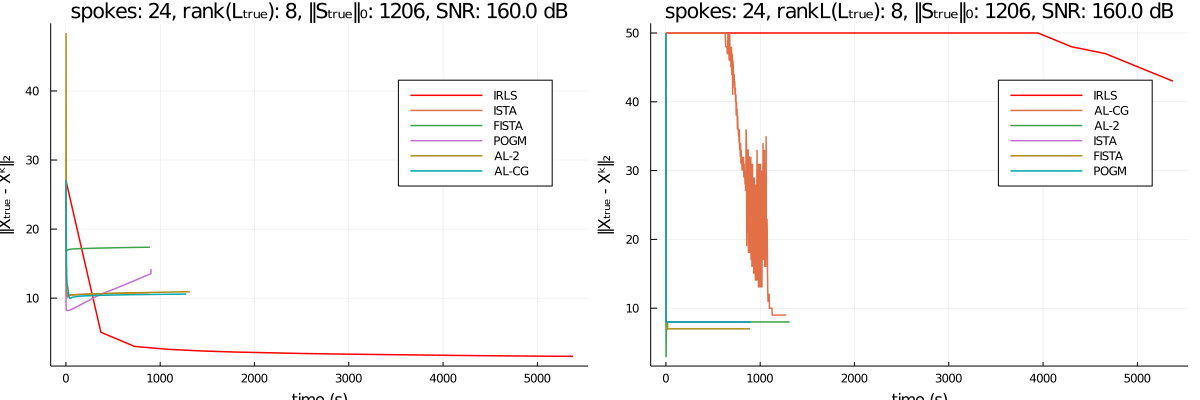

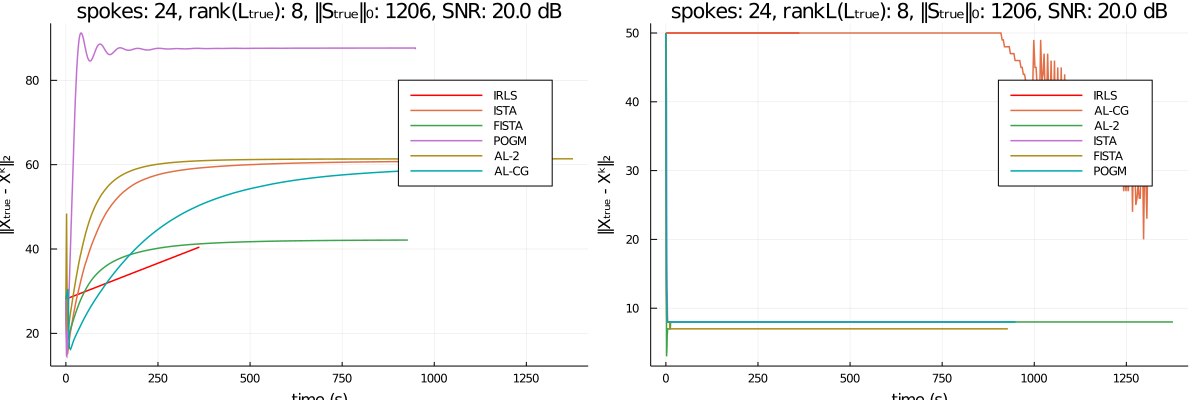

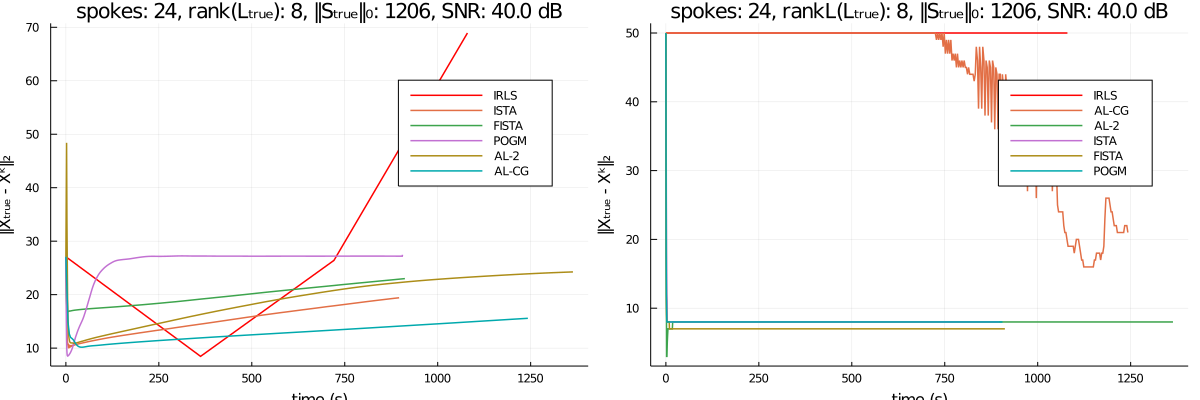

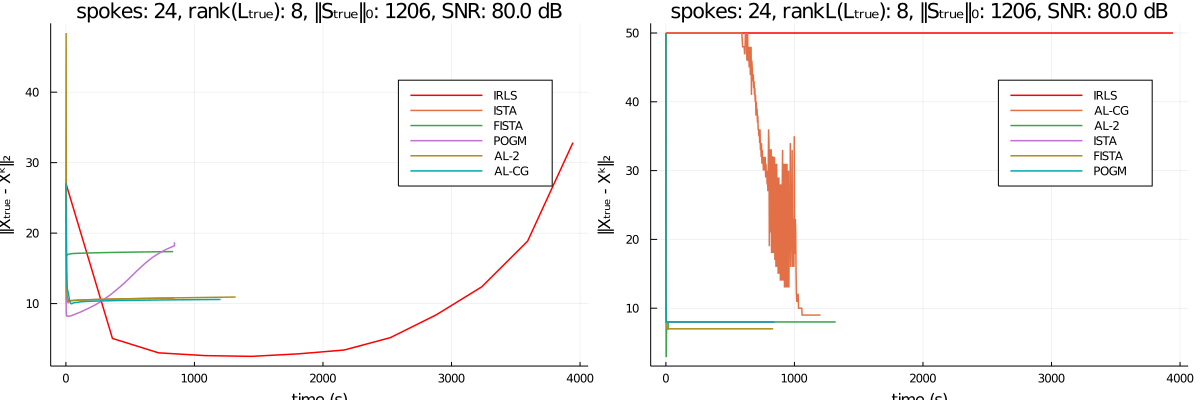

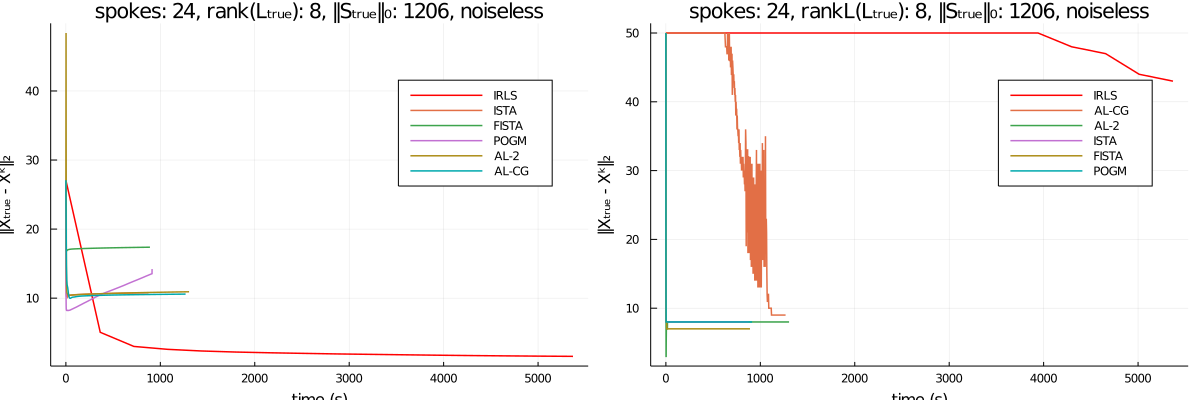

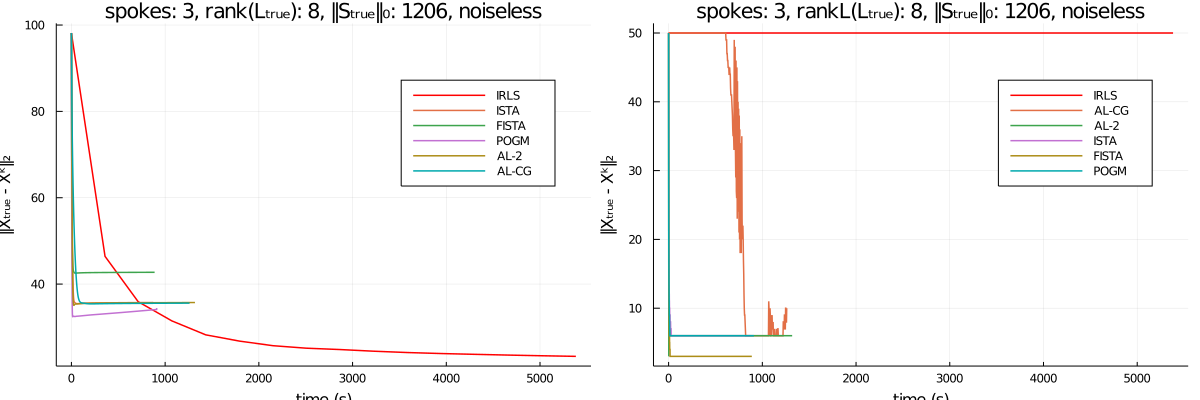

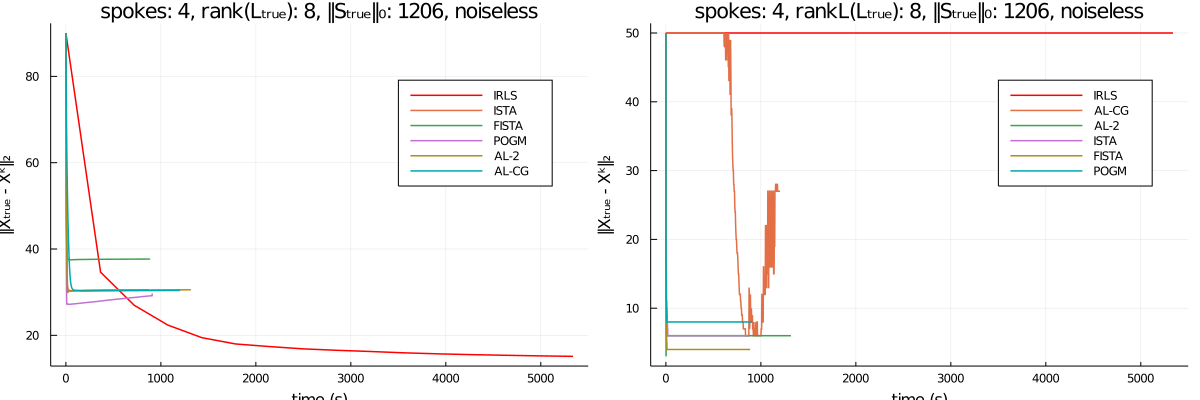

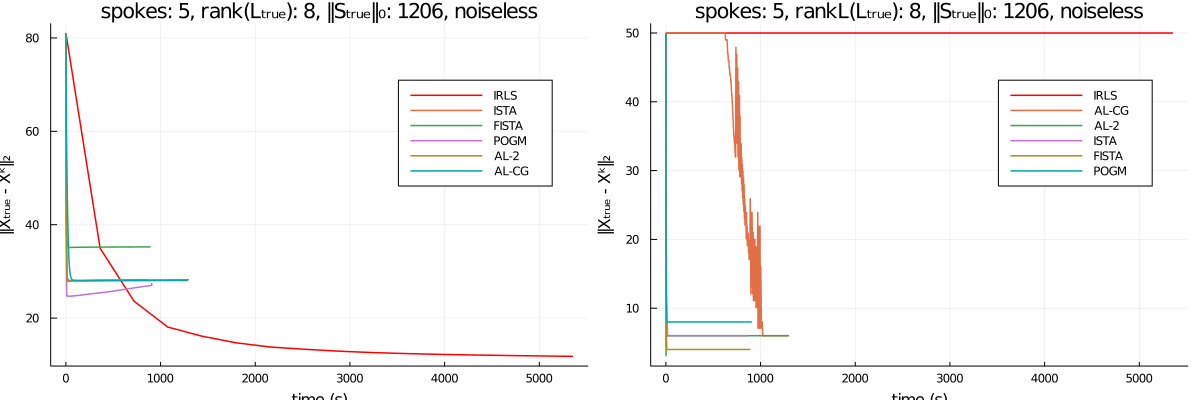

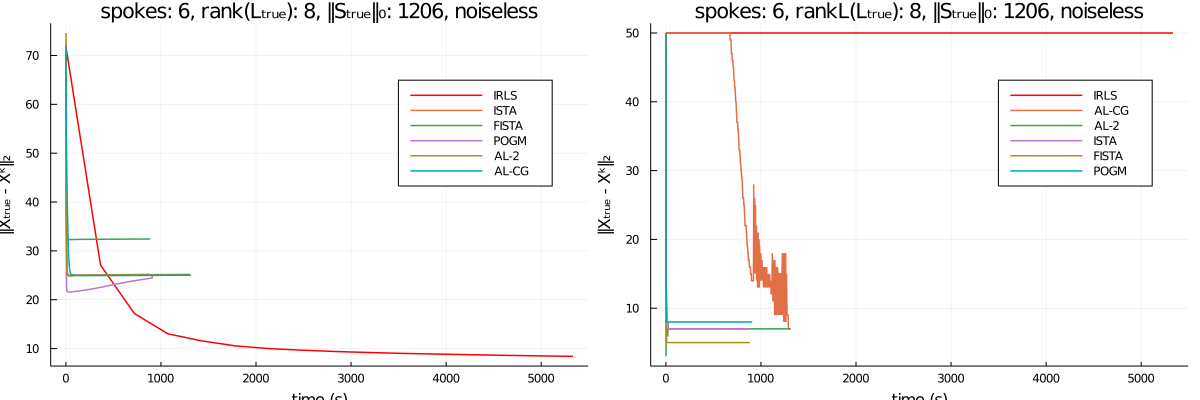

In [10]:
for (root, dirs, files) in walkdir("third_trial")
    for file in files
        if endswith(file, ".jld")
            path = joinpath(root, file)
            d = load(path)
            
            # ---- cost ----
            
            cost_irls = d["cost_irls"]
            time_irls = d["time_irls"]
            ff₁ = findfirst(cost_irls .> cost_irls[0])
            if !(ff₁ isa Nothing)
                cost_irls = cost_irls[0:ff₁]
                time_irls = time_irls[0:ff₁]
            else
                cost_irls = cost_irls[0:end]
                time_irls = time_irls[0:end]
            end
            
            noise = d["SNR_dB"] < Inf ? "SNR: " * string(d["SNR_dB"]) * " dB" : "noiseless"
            p_cost = plot(time_irls, cost_irls, label="IRLS",
                linewidth = 1.5, linecolor = :red,
                title = """spokes: $(d["line"]), rank(Lₜᵣᵤₑ): $(d["target_rank"]), ‖Sₜᵣᵤₑ‖₀: $(d["s"]), $noise""",
                xlabel = "time (s)", ylabel = "‖Xₜᵣᵤₑ - Xᵏ‖₂")
            
            plot!(d["time_ista"], d["cost_ista"], label="ISTA", linewidth = 1.5)
            plot!(d["time_fista"], d["cost_fista"], label="FISTA", linewidth = 1.5)
            plot!(d["time_pogm"], d["cost_pogm"], label="POGM", linewidth = 1.5)
            plot!(d["time_al"], d["cost_al"], label="AL-2", linewidth = 1.5)
            plot!(d["time_cg"], d["cost_cg"], label="AL-CG", linewidth = 1.5)
            
            cost_mslr = d["cost_mslr"]
            time_mslr = d["time_mslr"]
            ff₂ = findfirst(cost_mslr .> 100)
            if !(ff₂ isa Nothing)
                cost_mslr = cost_mslr[0:ff₂]
                time_mslr = time_mslr[0:ff₂]
            end
            #plot!(time_mslr, cost_mslr, label="MSLR", linewidth = 1.5)
            
            # ---- rank ----
            
            rankL_irls = d["rankL_irls"]
            if !(ff₁ isa Nothing)
                rankL_irls = rankL_irls[0:ff₁]
            else
                rankL_irls = rankL_irls[0:end]
            end
            
            p_rankL = plot(time_irls, rankL_irls, label="IRLS",
                linewidth = 1.5, linecolor = :red,
                title = """spokes: $(d["line"]), rankL(Lₜᵣᵤₑ): $(d["target_rank"]), ‖Sₜᵣᵤₑ‖₀: $(d["s"]), $noise""",
                xlabel = "time (s)", ylabel = "‖Xₜᵣᵤₑ - Xᵏ‖₂")
            
            plot!(d["time_cg"], d["rankL_cg"], label="AL-CG", linewidth = 1.5)
            plot!(d["time_al"], d["rankL_al"], label="AL-2", linewidth = 1.5)
            plot!(d["time_ista"], d["rankL_ista"], label="ISTA", linewidth = 1.5)
            plot!(d["time_fista"], d["rankL_fista"], label="FISTA", linewidth = 1.5)
            plot!(d["time_pogm"], d["rankL_pogm"], label="POGM", linewidth = 1.5)
            
            p = plot(p_cost, p_rankL, size = plot_size, layout = 2)
            display(p)
        end
    end
end

### Plot against number of steps (including number of inner steps)

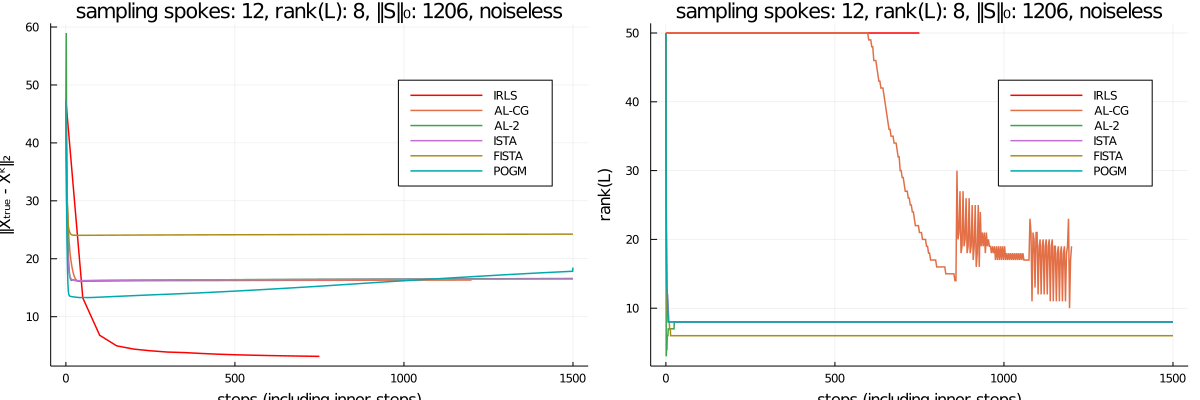

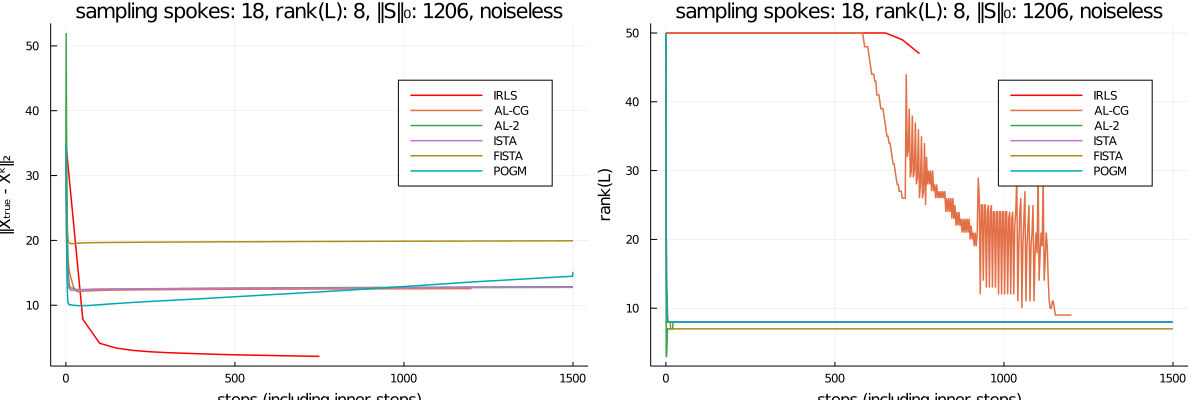

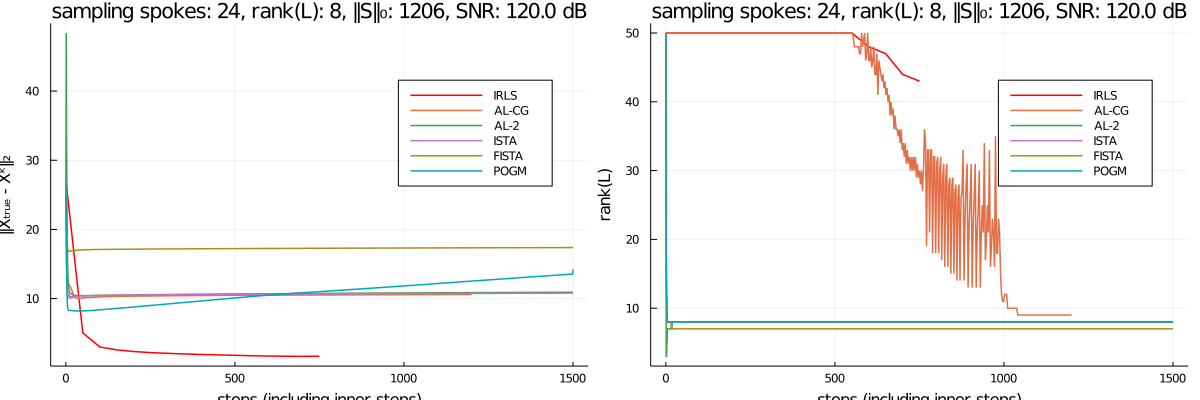

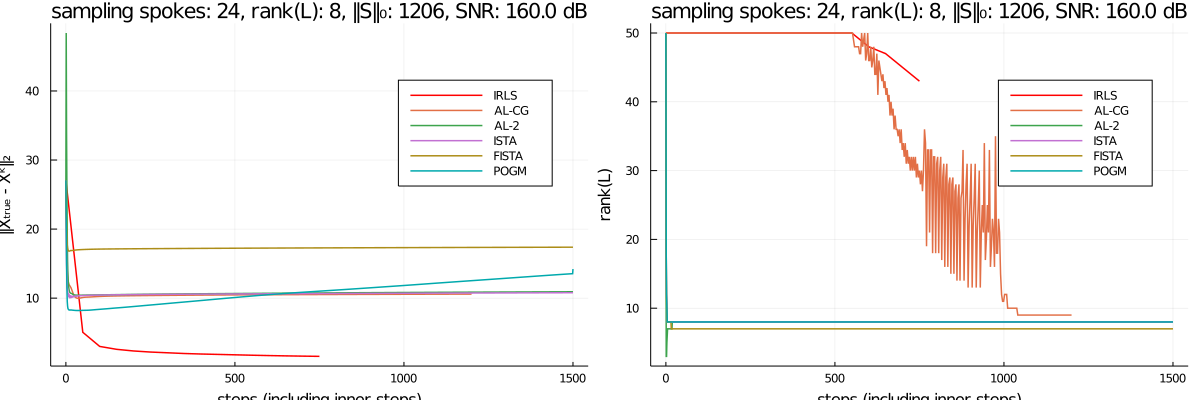

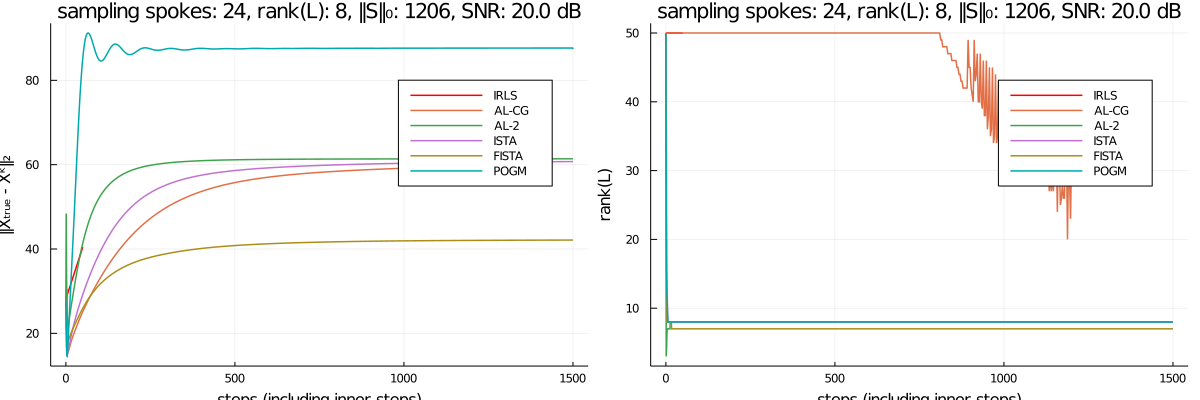

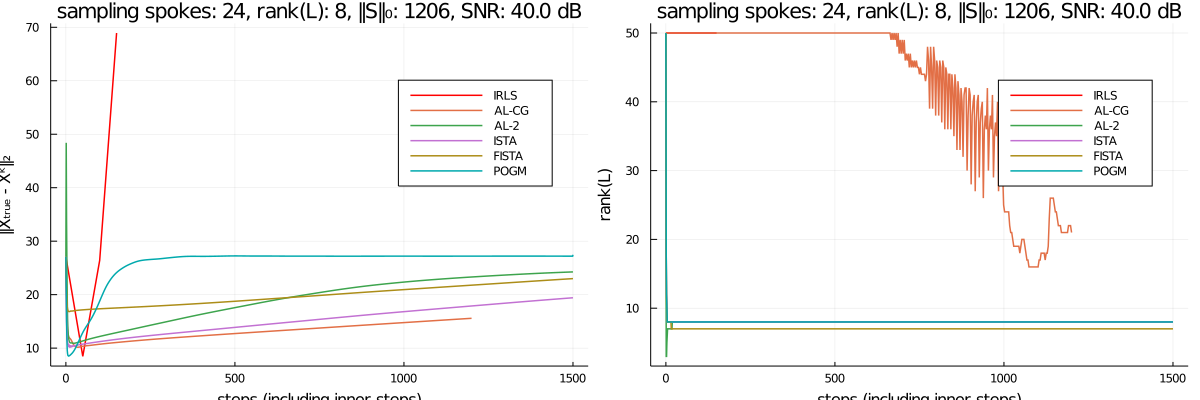

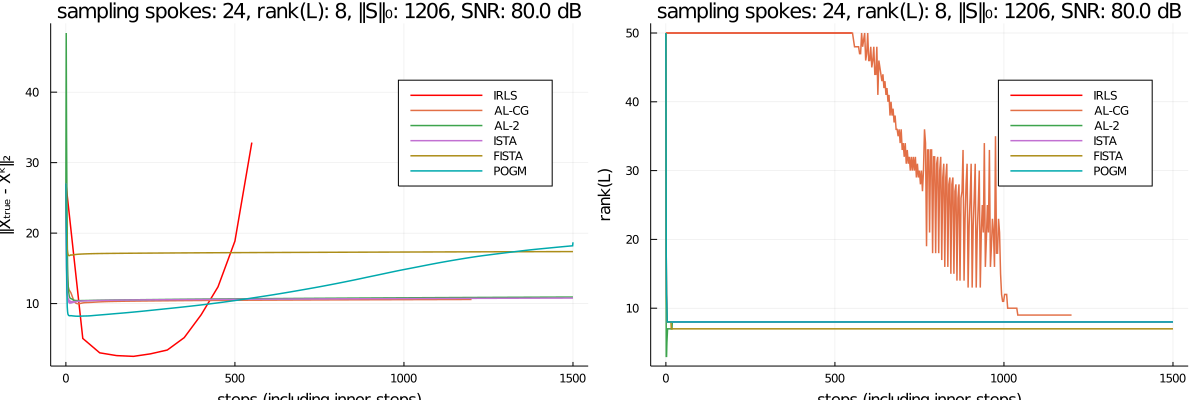

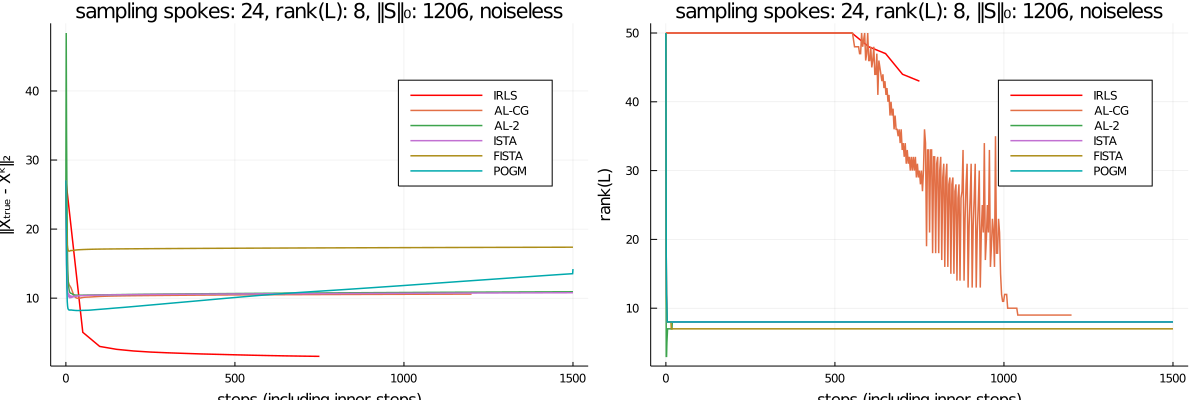

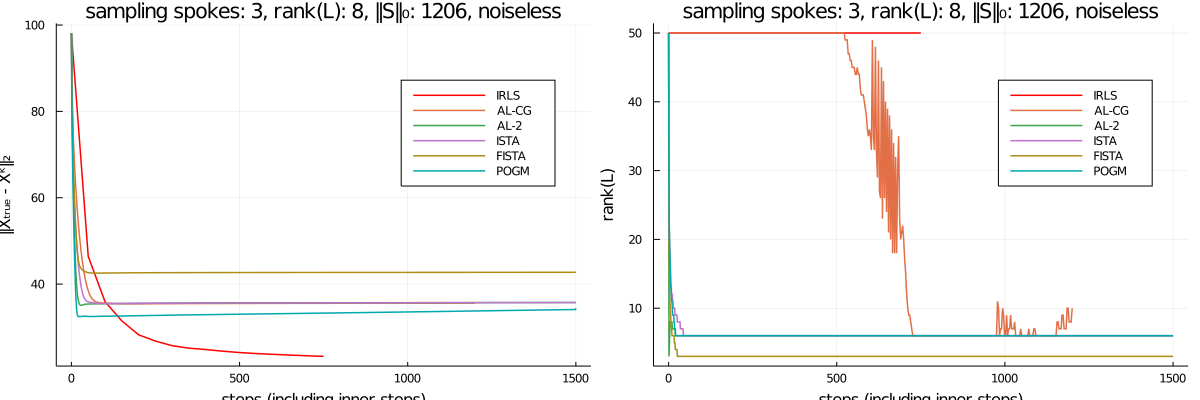

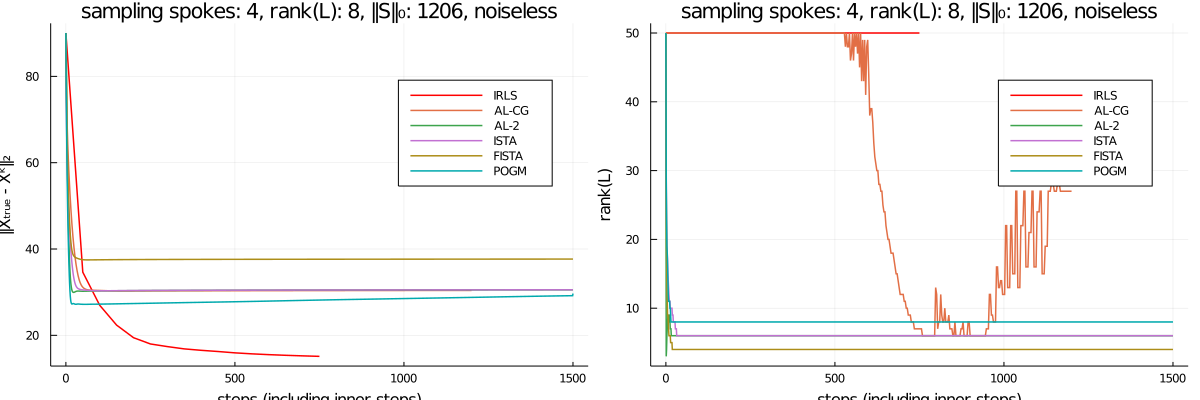

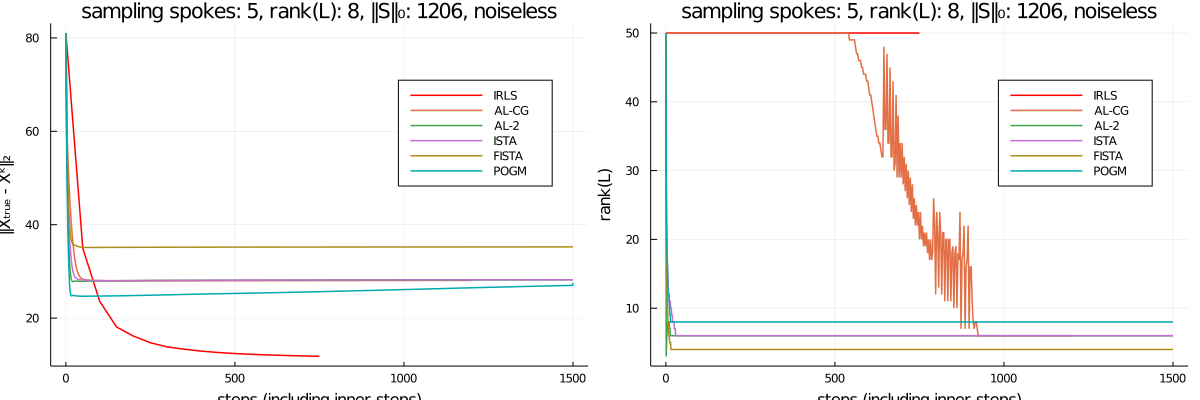

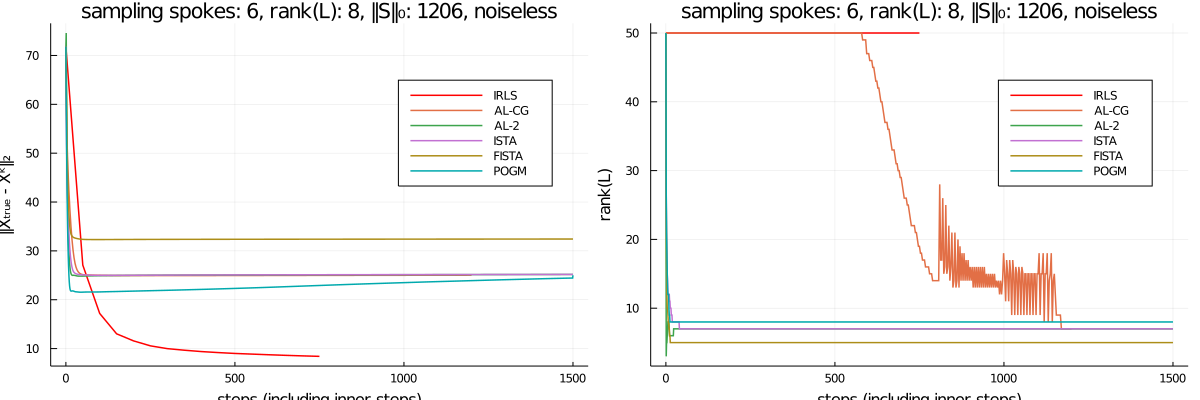

In [8]:
for (root, dirs, files) in walkdir("third_trial")
    for file in files
        if endswith(file, ".jld")
            path = joinpath(root, file)
            d = load(path)
            
            # ---- cost ----
            
            cost_irls = d["cost_irls"]
            ff₁ = findfirst(cost_irls .> cost_irls[0])
            if !(ff₁ isa Nothing)
                cost_irls = cost_irls[0:ff₁]
            else
                cost_irls = cost_irls[0:end]
            end
            
            noise = d["SNR_dB"] < Inf ? "SNR: " * string(d["SNR_dB"]) * " dB" : "noiseless"
            p_cost = plot(0:50:(length(cost_irls)-1)*50, cost_irls, label="IRLS",
                linewidth = 1.5, linecolor = :red,
                title = """sampling spokes: $(d["line"]), rank(L): $(d["target_rank"]), ‖S‖₀: $(d["s"]), $noise""",
                xlabel = "steps (including inner steps)", ylabel = "‖Xₜᵣᵤₑ - Xᵏ‖₂")
            
            plot!(0:3:(length(d["cost_cg"])-1)*3, no_offset_view(d["cost_cg"]), label="AL-CG", linewidth = 1.5)
            plot!(0:length(d["cost_al"])-1, no_offset_view(d["cost_al"]), label="AL-2", linewidth = 1.5)
            plot!(0:length(d["cost_ista"])-1, no_offset_view(d["cost_ista"]), label="ISTA", linewidth = 1.5)
            plot!(0:length(d["cost_fista"])-1, no_offset_view(d["cost_fista"]), label="FISTA", linewidth = 1.5)
            plot!(0:length(d["cost_pogm"])-1, no_offset_view(d["cost_pogm"]), label="POGM", linewidth = 1.5)
            
            cost_mslr = d["cost_mslr"]
            ff₂ = findfirst(cost_mslr .> cost_mslr[0])
            if !(ff₂ isa Nothing)
                cost_mslr = cost_mslr[0:ff₂]
            end
            #plot!(0:length(cost_mslr)-1, no_offset_view(cost_mslr), label="MSLR", linewidth = 1.5)
            
            # ---- rank ----
            
            rankL_irls = d["rankL_irls"]
            if !(ff₁ isa Nothing)
                rankL_irls = rankL_irls[0:ff₁]
            else
                rankL_irls = rankL_irls[0:end]
            end
            
            p_rank = plot(0:50:(length(rankL_irls)-1)*50, rankL_irls, label="IRLS",
                linewidth = 1.5, linecolor = :red,
                title = """sampling spokes: $(d["line"]), rank(L): $(d["target_rank"]), ‖S‖₀: $(d["s"]), $noise""",
                xlabel = "steps (including inner steps)", ylabel = "rank(L)")
            
            plot!(0:3:(length(d["cost_cg"])-1)*3, no_offset_view(d["rankL_cg"]), label="AL-CG", linewidth = 1.5)
            plot!(0:length(d["rankL_al"])-1, no_offset_view(d["rankL_al"]), label="AL-2", linewidth = 1.5)
            plot!(0:length(d["rankL_ista"])-1, no_offset_view(d["rankL_ista"]), label="ISTA", linewidth = 1.5)
            plot!(0:length(d["rankL_fista"])-1, no_offset_view(d["rankL_fista"]), label="FISTA", linewidth = 1.5)
            plot!(0:length(d["rankL_pogm"])-1, no_offset_view(d["rankL_pogm"]), label="POGM", linewidth = 1.5)
            
            
            p = plot(p_cost, p_rank, size = plot_size, layout = 2)
            display(p)
        end
    end
end

In [37]:
L"\Vert X_{true} - X_\infty \Vert_F"

L"$\Vert X_{true} - X_\infty \Vert_F$"